In [1]:
import pandas as pd
import numpy as np 
import argparse
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import smlmodule

from itertools import combinations

LIMIT = 0.95

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data



In [2]:
verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

#print(in_datapaper)

#for row in datapaper.iterrows():
#    print(row)


Paper data 
Age features 
Copernico data 


In [3]:
dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

DrepivIdx name 


In [4]:
provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Province list: 
   1   verbania
   2   trapani
   3   pistoia
   4   viterbo
   5   matera
   6   grosseto
   7   taranto
   8   siracusa
   9   massa
   10   latina
   11   palermo
   12   cremona
   13   lecco
   14   brescia
   15   rimini
   16   la_spezia
   17   piacenza
   18   arezzo
   19   torino
   20   trento
   21   lodi
   22   foggia
   23   oristano
   24   caserta
   25   prato
   26   bergamo
   27   bolzano
   28   nuoro
   29   cosenza
   30   terni
   31   ferrara
   32   rovigo
   33   udine
   34   frosinone
   35   crotone
   36   enna
   37   roma
   38   verona
   39   fermo
   40   agrigento
   41   macerata
   42   napoli
   43   sassari
   44   chieti
   45   belluno
   46   savona
   47   isernia
   48   pesaro
   49   ravenna
   50   forli
   51   pisa
   52   catania
   53   alessandria
   54   catanzaro
   55   ragusa
   56   biella
   57   siena
   58   vicenza
   59   brindisi
   60   pescara
   61   reggio_nell_emilia
   62   cuneo
   63   pordenone


In [5]:
counter = 0

# TODO important  Double check period1 same as paper ? 
pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "sum_wpm10_ex_q75_period1_2020,"+\
        "sum_wpm2p5_ex_q75_period1_2020,"+\
        "sum_wno2_ex_q75_period1_2020,"+\
        "sum_wno_ex_q75_period1_2020,"+\
        "sum_wnh3_ex_q75_period1_2020,"+\
        "sum_wpans_ex_q75_period1_2020,"+\
        "sum_wnmvoc_ex_q75_period1_2020,"+\
        "sum_wo3_ex_q75_period1_2020,"+\
        "sum_wco_ex_q75_period1_2020,"+\
        "sum_wso2_ex_q75_period1_2020"

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    if cases > 0.0 and diff < 5.0:
        counter += 1

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", "lat", "Ratio0200ver65"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))
    
    ycasi = cases/popolazione

    if cases > 0.0 and diff < 5.0:
        ylogpropcasi.append(math.log(ycasi))

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 


        i = i + 1


In [6]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict


sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


Using:                        density
Using:               commutersdensity
Using:                         depriv
Using:                            lat
Using:                 Ratio0200ver65
Using:  sum_wpm10_ex_q75_period1_2020
Using:   sum_wno2_ex_q75_period1_2020
Using:    sum_wno_ex_q75_period1_2020
Using:   sum_wnh3_ex_q75_period1_2020
Using:  sum_wpans_ex_q75_period1_2020
Using: sum_wnmvoc_ex_q75_period1_2020
Using:   sum_wso2_ex_q75_period1_2020

Highly correlated removing sum_wpm2p5_ex_q75_period1_2020
      sum_wpm10_ex_q75_period1_2020
 
Training set average RMSE:  0.35444  0.02536 
    Test set average RMSE:  0.95543  0.09497 
             Fullset RMSE:  0.34218
                       R2:  0.94642


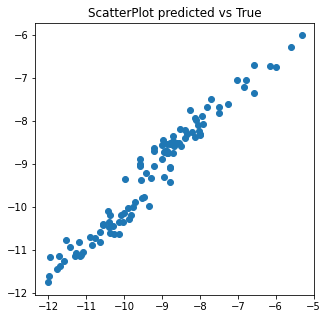


Features importance from model: 
Feature:                        density, Score: 0.04970
Feature:               commutersdensity, Score: 0.02607
Feature:                         depriv, Score: 0.05837
Feature:                            lat, Score: 0.69975
Feature:                 Ratio0200ver65, Score: 0.07907
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.00797
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01333
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02647
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00465
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.01926
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00958
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00579


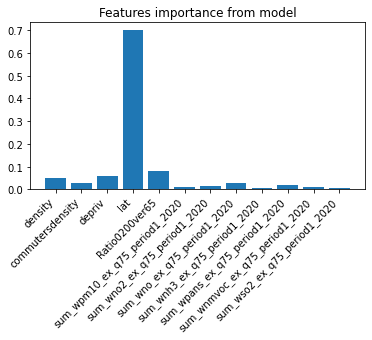


Features importance from Permutation: 
Feature:                        density, Score: 0.10783
Feature:               commutersdensity, Score: 0.05699
Feature:                         depriv, Score: 0.12252
Feature:                            lat, Score: 3.23403
Feature:                 Ratio0200ver65, Score: 0.28264
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02765
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01612
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05257
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00918
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06501
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01541
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01294


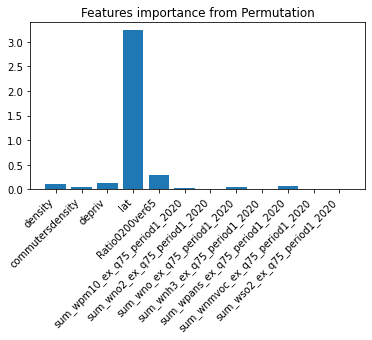

In [7]:
label = "casi"
prescript = "testpaper"

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

listostack = [features_dict[v] for v in features]
X = np.column_stack (listostack)

Y = np.asanyarray(ylogpropcasi)
#print(Y.shape)
#print(X.shape)
plt.figure(figsize=(5,5))
smlmodule.rfregressors (X, Y , features, plotname=prescript+label, N=50, pout=sys.stdout, showplot=True)
#smlmodule.knregressors (X, Y , features, N=50)
print("==============================================================================")

